In this section, we will discuss a model whose output can be expressed as probabilities. For example, the probability of passing the exam if we know the exam preparation time, the probability of it raining tomorrow based on information measured today, etc. This model is called *logistic regression*. Although the name contains the word regression, logistic regression is more commonly used for classification problems.

We will discuss the following example: Consider an example of the relationship between exam preparation time and exam results of 20 students given in the table below.

<p align="center">Table: Exam preparation time (Hours) and exam results of 20 students.</p>

| Hours | Pass |
|-------|------|
| 0.5   | 0    |
| 0.75  | 0    |
| 1     | 0    |
| 1.25  | 0    |
| 1.5   | 0    |
| 1.75  | 0    |
| 2     | 1    |
| 2.25  | 1    |
| 2.5   | 1    |
| 2.75  | 1    |
| 3     | 1    |
| 3.25  | 1    |
| 3.5   | 1    |
| 3.75  | 1    |
| 4     | 1    |
| 4.25  | 1    |
| 4.5   | 1    |
| 4.75  | 1    |
| 5     | 1    |
| 5.25  | 1    |
| 5.5   | 1    |

The problem is to build a model from this data to evaluate a student's ability to pass based on exam preparation time. In general, the more time you study, the higher your chances of passing. However, there is no threshold to confirm that every student who studies more than that threshold will definitely pass. In other words, the data of these two layers is not linearly separable, and so PLA will not be useful here. However, instead of accurately predicting the two pass/fail values, we can predict the probability that a student will pass the exam based on the exam preparation time.

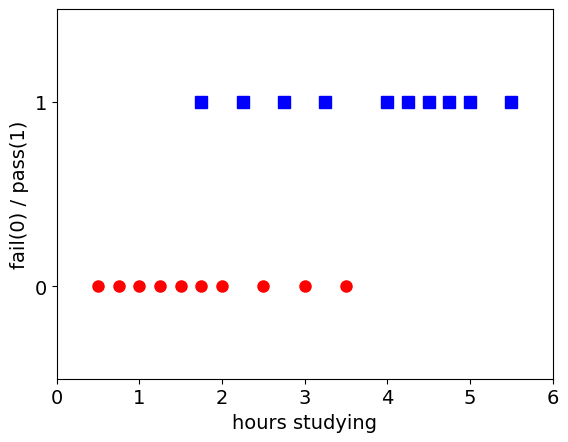

In [132]:
import numpy as np 
import matplotlib.pyplot as plt


np.random.seed(22)

X0 = np.array([.5, .75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5])
y0 = np.zeros_like(X0)

X1 = np.array([1.75, 2.25, 2.75, 3.25, 4, 4.25, 4.5, 4.75, 5, 5.5])
y1 = np.ones_like(X1)

plt.plot(X0, y0, 'ro', markersize = 8)
plt.plot(X1, y1, 'bs', markersize = 8)

plt.axis([0, 6, -.5, 1.5])
cur_axes = plt.gca()
plt.xlabel('hours studying', fontsize = 14)
plt.ylabel('fail(0) / pass(1)', fontsize = 14)
cur_axes.axes.get_yaxis().set_ticks([0, 1])
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

### Logistic regression model

We need a few important properties for the functions drawn in the figure below

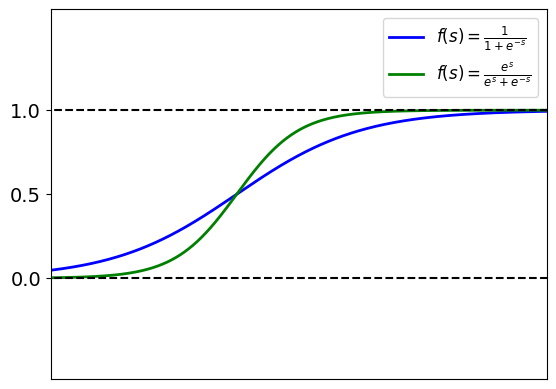

In [133]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

x = np.linspace(-5, 5, 1000)
y3 = 1./(1 + np.exp(-x))
y4 = np.exp(x) /(np.exp(x) + np.exp(-x))

l1, = plt.plot(x, y3, 'b', linewidth = 2, label = "$f(s) = \\frac{1}{1 + e^{-s}}$")
l2, = plt.plot(x, y4, 'g', linewidth = 2, label = "$f(s) = \\frac{e^{s}}{e^{s} + e^{-s}}$")
plt.plot(x, [1] * len(x), 'k--')
plt.plot(x, [0] * len(x), 'k--')

plt.legend(handles = [l1, l2], fontsize = 12)

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([0, 1/2, 1])

plt.axis([-3, 5, -.6, 1.6])
plt.tick_params(labelsize=14)
plt.show()

They have some properties from the functions above:

+ Are functions that continuously receive real values, bounded in the range $(0, 1)$.
+ If we consider the point with the ordinate $\frac{1}{2}$ as the threshold, points farther to the left of the threshold have values ​​closer to $0$, points farther to the right of the threshold have values ​​closer to almost $1$. This matches the observation that the more you study, the higher the probability of passing and vice versa.
+ These two functions have derivatives everywhere, so they can benefit from optimization.

1. Sigmoid function (function is bounded in the interval $(0, 1)$):

$$f(s) := \sigma(s) = \frac{1}{1 + e^{-s}} = \frac{e^s}{1 + e^s} = 1 - \sigma(-s)$$
$$\lim_{s\rightarrow -\infty}\sigma(s) = 0 \ ; \ \lim_{s\rightarrow +\infty}\sigma(s) = 1$$

Furthermore:

$$\sigma'(s) = \frac{e^{-s}}{(1 + e^{-s})^2} = \frac{1}{1 + e^{-s}}\frac{e^{-s}}{1 + e^{-s}} = \sigma(s)[1 - \sigma(s)]$$

With simple derivatives, the sigmoid function is widely used in neural networks.

In [134]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

2. Tanh function (function takes values ​​in the range $(−1, 1)$):

$$\tanh(s) = \frac{e^s - e^{-s}}{e^s + e^{-s}} = 2\sigma(2s) - 1$$

## Build the loss function

With the model above (blue and green activations), we can assume that the probability that a data point $\mathbf{x}$ falls into class $1$ is $f(\mathbf{w}^ T\mathbf{x})$, and falling into class $0$ is $1 - f(\mathbf{w}^T\mathbf{x})$. With the model assumed as such, with training data points (output $y$ known), we can write as follows:

$$\mathbb{P}(y_i = 1|\mathbf{x}_i; \mathbf{w}) = f(\mathbf{w}^ T\mathbf{x})$$
$$\mathbb{P}(y_i = 0|\mathbf{x}_i; \mathbf{w}) = 1 - f(\mathbf{w}^ T\mathbf{x})$$

Our goal is to find the coefficients $\mathbf{w}$ such that $f(\mathbf{w}^ T\mathbf{x})$ is as close to $1$ as possible for data points belonging to class $1 $ and as close to $0$ as possible for points of class $0$.

Notation $z_i = f(\mathbf{w}^ T\mathbf{x})$ and combining the two expressions above, we have:

$$\mathbb{P}(y_i|\mathbf{x}_i; \mathbf{w}) = z_i^{y_i}(1 - z_i)^{1 - y_i}$$

Consider the entire test set with data matrix $\mathbf{X} = [\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N]\in\mathbb{R}^ {d\times N}$ and the output vector corresponding to each column $\mathbf{y} = [y_1, y_2, \ldots, y_N]$. We need to find $\mathbf{w}$ to maximize the following expression:

$$\mathbb{P}(\mathbf{y}|\mathbf{X}; \mathbf{w})$$

In other words, we need to solve the optimization problem

$$\mathbf{w} = {\underset{\mathbf{w}}{\operatorname{arg\,max}}} \ \mathbb{P}(\mathbf{y}|\mathbf{X}; \mathbf{w})$$ 

This is a maximum likelihood estimation problem with model parameters $\mathbf{w}$ that need to be estimated. Assuming further that the data points are randomly generated independently of each other, we can write

$$\mathbb{P}(\mathbf{y}|\mathbf{X}; \mathbf{w}) = \prod_{i=1}^N\mathbb{P}(y_i|\mathbf{x}_i; \mathbf{w}) = \prod_{i=1}^N z_i^{y_i}(1 - z_i)^{1 - y_i}$$

There is a problem when $N$ is large, the product of $N$ numbers smaller than $1$ can lead to numerical error because the product is too small a number. A commonly used method is to take the natural logarithm (base $e$) of the likelihood function to turn multiplication into addition and to avoid numbers that are too small. Then take the opposite sign to get a loss function. Now the problem of finding maximum likelihood values ​​becomes the problem of finding the smallest value of the loss function (this function is also called negative log likelihood)

$$J(\mathbf{w}) = -\frac{1}{N}\log\mathbb{P}(\mathbf{y}|\mathbf{X}; \mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N[y_i\log z_i + (1 - y_i)\log(1 - z_i)]$$

with note that $z_i$ is a function of $\mathbf{w}$ and $\mathbf{x}_i$. So we will need to find $\mathbf{w}$ so that $J(\mathbf{w})$ reaches its smallest value.

## Optimize the loss function

The problem of optimizing the loss function of logistic regression can be solved by stochastic gradient descent (SGD). At each loop, $\mathbf{w}$ will be updated based on a random data point. The loss function of logistic regression with only one data point $(\mathbf{x}_i, y_i)$ and its derivative are respectively

$$J(\mathbf{w; x}_i; y_i) = -[y_i\log z_i + (1 - y_i)\log(1 - z_i)]$$
$$\frac{\partial J(\mathbf{w; x}_i; y_i)}{\partial\mathbf{w}} = -\left(\frac{y_i}{z_i} - \frac{1 - y_i}{1 - z_i}\right)\frac{\partial z_i}{\partial\mathbf{w}} = \frac{z_i - y_i}{z_i(1 - z_i)}\frac{\partial z_i}{\partial\mathbf{w}}\tag{1}$$

To make this expression more compact and beautiful, we will find the function $z = f(\mathbf{w}^T\mathbf{x})$ so that the denominator cancels out. If we set $s = \mathbf{w}^T\mathbf{x}$, we get

$$\frac{\partial z_i}{\partial \mathbf{w}} = \frac{\partial z_i}{\partial s} \frac{\partial s}{\partial \mathbf{w}} = \frac{\partial z_i}{\partial s} \mathbf{x} \tag{2}$$

Naturally, we will find the function $z = f(s)$ such that

$$\frac{\partial z}{\partial s} = z(1 - z)\tag{3}$$

This equation is equivalent to

$$
\begin{align*}
& \frac{\partial z}{z(1-z)} &=& \ \partial s\\
\Leftrightarrow & \ \left(\frac{1}{z} + \frac{1}{1 - z}\right)\partial z &=& \ \partial s\\
\Leftrightarrow & \ \log z - \log(1 - z) &=& \ s + C\\
\Leftrightarrow & \ \log \frac{z}{1 - z} &=& \ s + C\\
\Leftrightarrow & \ \frac{z}{1 - z} &=& \ e^{s+C}\\
\Leftrightarrow & \ z &=& \ e^{s+C}(1 - z)\\
\Leftrightarrow & \ z = \frac{e^{s+C}}{1 +e^s} &=& \ \frac{1}{1 + e^{-s-C}} = \sigma(s + C)
\end{align*}
$$

where $C$ is a constant. Simply choosing $C = 0$, we get 

$$z = f(\mathbf{w}^T\mathbf{x}) = \sigma(s)\tag{4}$$

This is why the sigmoid function was born and Logistic regression with activation function is the most commonly used sigmoid function. Substituting $2, 3, 4$ into $1$, we get

$$\frac{\partial J(\mathbf{w; x}_i; y_i)}{\partial\mathbf{w}} = (z_i - y_i)\mathbf{x}_i = [\sigma(\mathbf{w}^T\mathbf{x}_i) - y_i]\mathbf{x}_i$$

And the solution update formula for logistic sigmoid regression using SGD is

$$\mathbf{w}\leftarrow\mathbf{w} - \eta[\sigma(\mathbf{w}^T\mathbf{x}_i) - y_i]\mathbf{x}_i$$

where $\eta$ is a positive learning rate.

## Logistic regression with weight decay

One of the popular techniques to help avoid overfitting with neural networks is to use weight decay. Weight decay is a regularization technique in which a quantity proportional to the square of $\text{norm} \ 2$ of the coefficient vector is added to the loss function to limit the magnitude of the coefficients. The loss function becomes

$$J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N\left[-y_i\log z_i - (1 - y_i)\log(1 - z_i) + \frac{\lambda}{2}||\mathbf{w}||_2^2\right]$$

The formula for updating SGD for $\mathbf{w}$ with this function is also simple because the regularization part has a simple derivative

$$\mathbf{w}\leftarrow\mathbf{w} - \eta([\sigma(\mathbf{w}^T\mathbf{x}_i) - y_i]\mathbf{x}_i + \lambda\mathbf{w})$$

## Example with Python

In [135]:
def loss(w, X, y, lam=0.001):
    z = sigmoid(np.dot(w.T, X))
    return -np.mean(y*np.log(z) + (1-y)*np.log(1-z)) + 0.5*lam/X.shape[1]*np.sum(w*w)

def logistic_sigmoid_regression(X, y, w_init, eta, lam = .001, tol = 1e-4, max_count = 10000):
    w = [w_init]    
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    count = 0
    check_w_after = 20
    loss_hist = [loss(w_init, X, y, lam)]
    while count < max_count:
        # mix data 
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = y[i]
            zi = sigmoid(np.dot(w[-1].T, xi))
            w_new = w[-1] - eta*((zi - yi)*xi + lam*w[-1])
            loss_hist.append(loss(w_new, X, y, lam))
            count += 1
            # stopping criteria
            if count % check_w_after == 0:                
                if np.linalg.norm(w_new - w[-check_w_after]) < tol:
                    return (w, loss_hist)
            w.append(w_new)
    return (w, loss_hist)

In [136]:
X = np.array([[0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50]])
y = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

# extended data 
X = np.concatenate((np.ones((1, X.shape[1])), X), axis=0)
print(f'X = \n{X}\ny = {y}')

X = 
[[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.  ]
 [0.5  0.75 1.   1.25 1.5  1.75 1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
  4.   4.25 4.5  4.75 5.   5.5 ]]
y = [0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1]


In [137]:
eta = .05 
d = X.shape[0]
w_init = np.random.randn(d, 1)

(w, loss_hist) = logistic_sigmoid_regression(X, y, w_init, eta)
print(f'Solution of Logistic Regression: {w[-1].T[0]}')
print(f'Final loss: {loss_hist[-1]}')

Solution of Logistic Regression: [-3.85101959  1.49162482]
Final loss: 0.4043126777900746


From here we can derive the probability of passing the exam based on the formula

$$\text{Probability of pass}\approx\text{sigmoid}(-3.85101959 + \text{hours of studying} * 1.49162482)$$

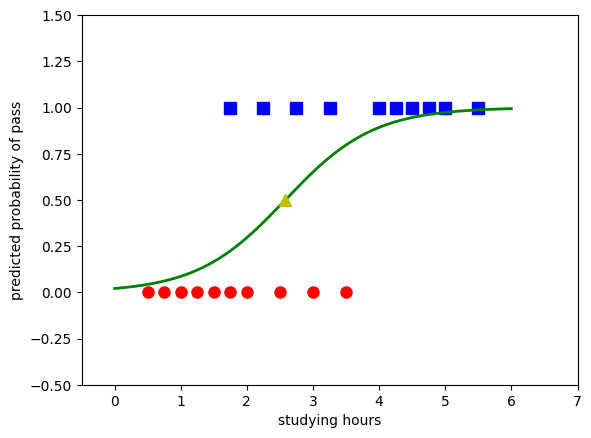

In [138]:
X0 = X[1, np.where(y == 0)][0]
y0 = y[np.where(y == 0)]
X1 = X[1, np.where(y == 1)][0]
y1 = y[np.where(y == 1)]

plt.plot(X0, y0, 'ro', markersize = 8)
plt.plot(X1, y1, 'bs', markersize = 8)

xx = np.linspace(0, 6, 1000)
w0 = w[-1][0][0]
w1 = w[-1][1][0]
threshold = -w0/w1
yy = sigmoid(w0 + w1*xx)
plt.axis([-.5, 7, -.5, 1.5])
plt.plot(xx, yy, 'g-', linewidth = 2)
plt.plot(threshold, .5, 'y^', markersize = 8)
plt.xlabel('studying hours')
plt.ylabel('predicted probability of pass')
plt.show()

The green line represents the probability of passing based on study time. The golden triangle point represents the pass/fail decision threshold. This point may change depending on the problem.

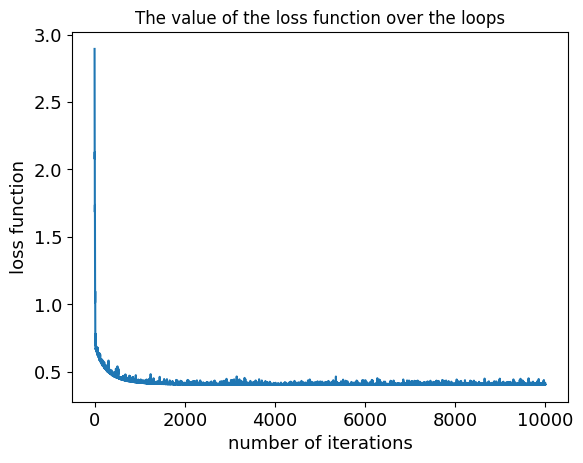

In [139]:
plt.plot(loss_hist)
plt.title('The value of the loss function over the loops')
plt.xlabel('number of iterations', fontsize = 13)
plt.ylabel('loss function', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

The loss function decreases very quickly and converges after 10000 iterations.

### Example of 2D data

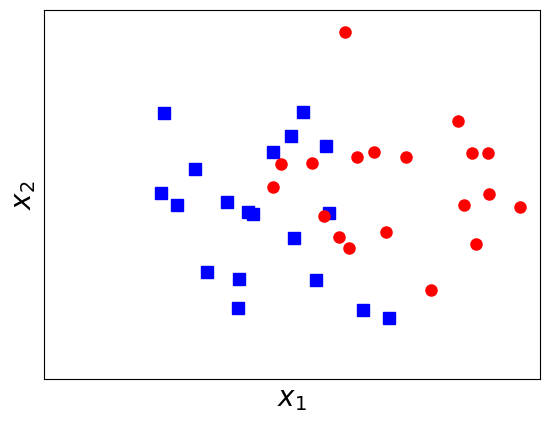

In [140]:
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)

plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

# hide tikcs 
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.show()

In [141]:
X = np.concatenate((X0, X1), axis=0).T
y = np.concatenate((np.zeros((1, N)), np.ones((1, N))), axis=1).T
# Xbar 
X = np.concatenate((np.ones((1, 2*N)), X), axis=0)

print(f'X = \n{X}\n\ny = \n{y}')

X = 
[[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.92306918  2.90509186  1.58909188  2.76874122  2.52416203  2.02414192
   2.49174878  1.11439322  2.62561276  3.27183166  3.55617919  1.45945603
   2.87575608  2.30375703  1.08925412  4.09096119  1.80350003  1.25827634
   2.08532169  1.9340609   4.49775285  3.07311718  3.52528933  2.39091046
   3.12302646  4.62359547  3.38696098  4.36167918  3.21261415  2.71754956
   4.01073111  3.11892586  2.29402636  3.7365999   4.29699439  4.63617269
   2.84870815  4.45368062  4.97052399  3.01324102]
 [ 0.775673    1.7997662   1.16143907  1.07663514  1.

In [142]:
eta = .05 
d = X.shape[0]
w_init = np.random.randn(d, 1)

(w, loss_hist) = logistic_sigmoid_regression(X, y, w_init, eta)
print(w[-1])

[[-7.94652407]
 [ 1.89201308]
 [ 1.15765465]]


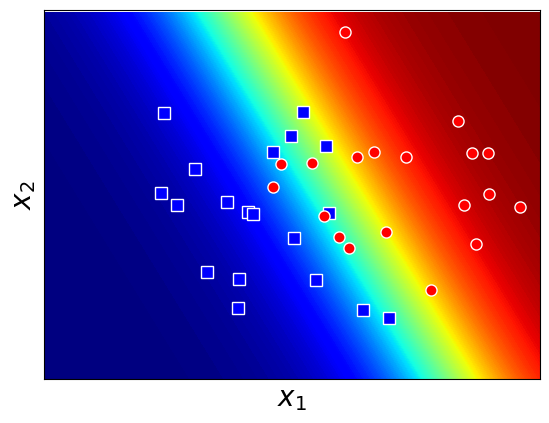

In [143]:
# Make data.
xm = np.arange(-1, 6, 0.025)
xlen = len(xm)
ym = np.arange(0, 4, 0.025)
ylen = len(ym)
xm, ym = np.meshgrid(xm, ym)
w0 = w[-1][0][0]
w1 = w[-1][1][0]
w2 = w[-1][2][0]
zm = sigmoid(w0 + w1*xm + w2*ym)

CS = plt.contourf(xm, ym, zm, 200, cmap='jet') # `contourf` is for filled contour plot

plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1, markeredgecolor = 'w')
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1, markeredgecolor = 'w')
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

# hide tikcs 
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.show()

The darker the red area represents the higher probability of belonging to the red data class, the darker the blue area represents the lower probability of belonging to the red data class - that is, the higher the probability of belonging to the blue data class. The boundary between two classes represents points that belong to each class with lower probability (lower confidence). If we have to choose a hard threshold (rather than accept probability) to separate the two classes, we observe that the line lying in the green area is a reasonable choice. Below is a demonstration that the dividing line between two classes found by logistic regression is in the form of a flat line, which is still linear.

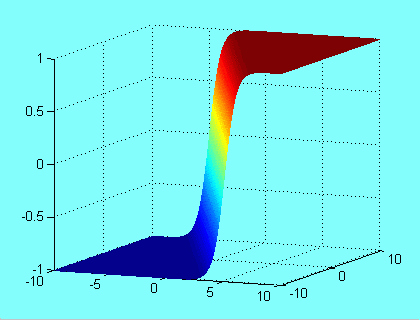

Suppose points with output probability greater than $0.5$ are considered to belong to the class labeled $1$. This set of points is the solution of the inequality

$$\mathbb{P}(y = 1|\mathbf{x; w}) > 0.5\Leftrightarrow\frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}}} > 0.5\Leftrightarrow e^{-\mathbf{w}^T\mathbf{x}} < 1\Leftrightarrow\mathbf{w}^T\mathbf{x} > 0$$

In other words, the set of points of class $1$ forms the halfspace $\mathbf{w}^T\mathbf{x} > 0$ the set of points of the class $0$ forms the remaining halfspace. again. The boundary between the two layers is the hyperplane $\mathbf{w}^T\mathbf{x} = 0$. Because of this, logistic regression is considered a linear classifier.

## Logistic Regression for the handwritten digit discrimination problem

In [144]:
import numpy as np 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

mnist = fetch_openml('mnist_784', version=1) # version 1 is the first version of MNIST dataset
N, d = mnist.data.shape
print('Total {:d} digits, each has {:d} pixels.'.format(N, d))

Total 70000 digits, each has 784 pixels.


In [146]:
X_all, y_all = mnist.data, mnist.target

X0 = X_all[y_all == '0']  # all digit 0
X1 = X_all[y_all == '1']  # all digit 1
y0 = np.zeros(X0.shape[0]) # label for digit 0
y1 = np.ones(X1.shape[0])  # label for digit 1

X = np.concatenate((X0, X1), axis = 0)
y = np.concatenate((y0, y1), axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42)

In [147]:
model = LogisticRegression(C = 1e5) # C is inverse of lam 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy %.2f %%" % (100*accuracy_score(y_test, y_pred)))

Accuracy 99.85 %


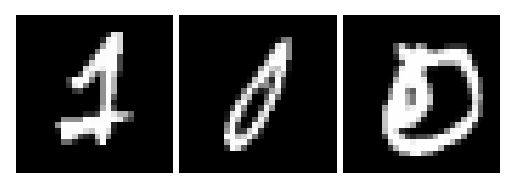

In [148]:
# Display misclassified images

mis = ((y_pred - y_test) != 0)
Xmis = X_test[mis, :]

from display_network import * 

plt.axis('off')
A = display_network(Xmis.T, 1, Xmis.shape[0])
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

In [150]:
# all class 

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=10000, random_state=42)

model = LogisticRegression(C = 1e5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy %.2f %%" % (100*accuracy_score(y_test, y_pred)))

Accuracy 92.05 %


/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


___
## **References:**

$[1].$ Hữu Vũ, T. (2018). _Machine Learning cơ bản_ (Vol. 14), Nhà xuất bản khoa học và kỹ thuật.

$[2].$ [Biased and non biased neurons.](http://galaxy.agh.edu.pl/~vlsi/AI/bias/bias_eng.html)